<a href="https://colab.research.google.com/github/anthonybabich/cap-comp215/blob/main/Langtons_ant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 2 - Langtons Ant
---------------------------
####Author: Anthony Babich

####Date: 2023-03-31

The purpose of this project is to develop a 2D cellular automata for langtons ant, do some experiments with the class, and then do an algorithim analysis.

Backround info: Langton's ant is a 2D CA with simple rules but complex emergent behaviour, invented by Chris Langton in 1986. 
The universality of Langton's ant was proven in 2000. The dynamics of Langton's ant have been the subject of extensive study and exploration in the field of complex systems, and have been used as a model for studying the emergence of complexity in natural systems.


In [34]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
%matplotlib inline
matplotlib.rc('animation', html='jshtml')
from matplotlib.patches import Circle
import timeit
from scipy.signal import correlate2d
import time






First is an animation class taken from Lab 6. This will be used to create stop motion animations for the cellular automnata

In [35]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 1 parameter, the matpltolib axes to draw on
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close() 
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  
                self.ax.clear()          
                plt.figure(self.fig)     
                self.animation_step(i)
                plt.show()              
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass


####Langtons Ant
Here is the implementation of langtons ant. 

The code defines two classes: Grid and LangtonsAnt.



* Grid class: This class represents the grid of cells that the ant moves across. It takes in three parameters: rows and columns (the dimensions of the grid) and state_values (a list of two values representing the two possible states of a cell - typically, black and white). It initializes the grid with all cells set to the default state (0).
*   LangtonsAnt class: This class represents the ant and its behavior. It takes in the same three parameters as Grid (rows, columns, and state_values), as well as three additional parameters: ant_row and ant_col (the starting position of the ant on the grid) and ant_direction (the starting direction of the ant). It initializes the grid and the ant's starting position and direction.

The LangtonsAnt class has the following methods:


*   get_ant_position(): This method returns the current position of the ant on the grid
*   step(): This method moves the ant one step forward based on its current position and the color of the cell it lands on. It updates the ant's position and direction, as well as the color of the cell it lands on.


*   draw(): This method takes in an Axes object (from matplotlib) and uses it to draw the current state of the grid (including the ant) on a plot.
*   repr(): This method returns a string representation of the LangtonsAnt object.

The rules for Langton's Ant are as follows:


*   If the ant is on a white cell, it turns 90 degrees clockwise, flips the color of the cell to black, and moves forward one cell.
*   If the ant is on a black cell, it turns 90 degrees counterclockwise, flips the color of the cell to white, and moves forward one cell.








In [36]:
class Grid:
    """
    Grid class that represents the state of each cell in the Langton's Ant simulation.
    """
    def __init__(self, rows, cols, state_values):
        self.rows = rows
        self.cols = cols
        self.grid = np.zeros((rows, cols), dtype=np.uint8)
        self.state_values = state_values

    def get_value(self, row, col):
        return self.grid[row, col]

    def set_value(self, row, col, value):
        self.grid[row, col] = value

    def flip_value(self, row, col):
        current_value = self.get_value(row, col)
        new_value = self.state_values[0] if current_value == self.state_values[1] else self.state_values[1]
        self.set_value(row, col, new_value)

    def __repr__(self):
        return f"Grid({self.rows}, {self.cols}, {self.grid})"


class LangtonsAnt:
    """
    Langton's Ant Cellular Automata class.
    """
    def __init__(self, rows, cols, state_values, ant_row, ant_col, ant_direction):
        self.grid = Grid(rows, cols, state_values)
        self.ant_row = ant_row
        self.ant_col = ant_col
        self.ant_direction = ant_direction


    def get_ant_position(self):
        return self.ant_row, self.ant_col

    def step(self):
       ant_row, ant_col = self.get_ant_position()
       ant_color = self.grid.get_value(ant_row, ant_col)
       self.grid.flip_value(ant_row, ant_col)

       if ant_color == self.grid.state_values[0]:  
        if self.ant_direction == "up":
            new_col = ant_col + 1
            if new_col < self.grid.cols:
                self.ant_col = new_col
                self.ant_direction = "right"
        elif self.ant_direction == "right":
            new_row = ant_row + 1
            if new_row < self.grid.rows:
                self.ant_row = new_row
                self.ant_direction = "down"
        elif self.ant_direction == "down":
            new_col = ant_col - 1
            if new_col >= 0:
                self.ant_col = new_col
                self.ant_direction = "left"
        elif self.ant_direction == "left":
            new_row = ant_row - 1
            if new_row >= 0:
                self.ant_row = new_row
                self.ant_direction = "up"

       elif ant_color == self.grid.state_values[1]:  
        if self.ant_direction == "up":
            new_col = ant_col - 1
            if new_col >= 0:
                self.ant_col = new_col
                self.ant_direction = "left"
        elif self.ant_direction == "right":
            new_row = ant_row - 1
            if new_row >= 0:
                self.ant_row = new_row
                self.ant_direction = "up"
        elif self.ant_direction == "down":
            new_col = ant_col + 1
            if new_col < self.grid.cols:
                self.ant_col = new_col
                self.ant_direction = "right"
        elif self.ant_direction == "left":
            new_row = ant_row + 1
            if new_row < self.grid.rows:
                self.ant_row = new_row
                self.ant_direction = "down"
        
        
    def draw(self, ax):
        ant_row, ant_col = self.get_ant_position()
        ax.clear()
        ax.imshow(self.grid.grid, cmap="binary")
        ax.add_artist(Circle((ant_col + 0.5, ant_row + 0.5), 0.4, color="red"))
         
      
    def __repr__(self):
        return f"LangtonsAnt({self.grid}, {self.ant_row}, {self.ant_col}, {self.ant_direction})"


####The Experiment 

The red dot which represents the ant seems to start off moving in a fairly simple and self contained way. However, for longer time steps it starts to become more chaotic and random.

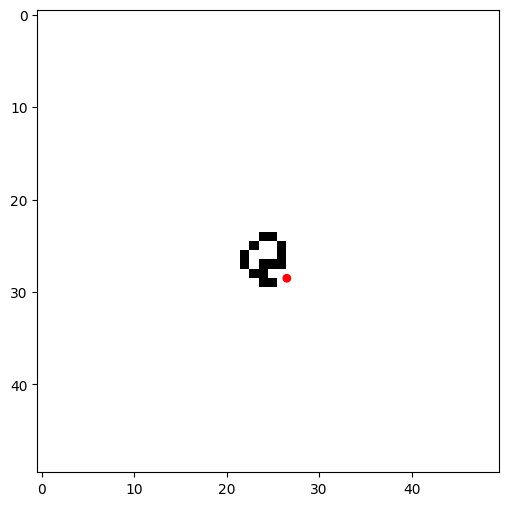

In [37]:
ant = LangtonsAnt(rows=50, cols=50, state_values=[0, 1], ant_row=25, ant_col=25, ant_direction="up")
anim = Animation2D(ant, frames=300, figsize=(6, 6))
anim.animate(interval=0.05)



Since it can take a long time to run 11,000 timesteps I plotted the final state after 11,000 time steps to observe what behaviour emerges. The langtons ant seems to come to regular behaviour in the last hundred time steps to build a highway 

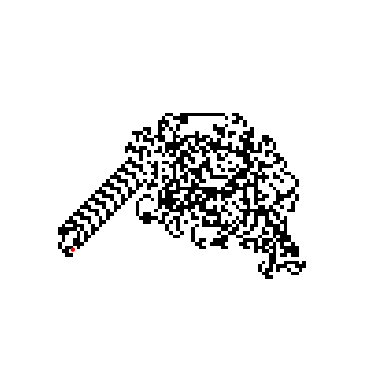

In [45]:
ant = LangtonsAnt(rows=100, cols=100, state_values=[0, 1], ant_row=50, ant_col=50, ant_direction="up")


for i in range(11000):
    ant.step()


fig, ax = plt.subplots()
ant.draw(ax)
plt.axis('off')
plt.savefig('langtons_ant.png', dpi=300, bbox_inches='tight')


Here is another Langton ant with some more state values and the ant direction as down. 

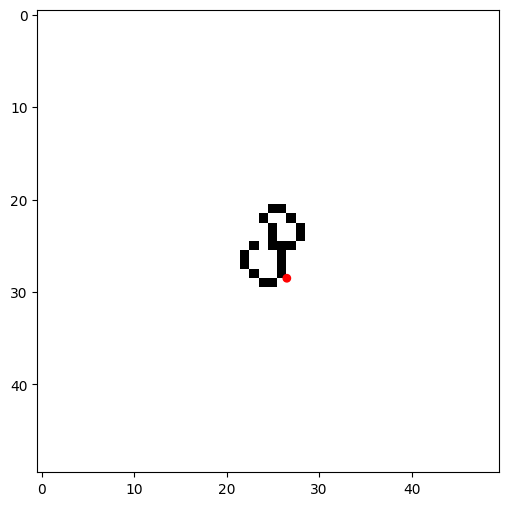

In [39]:
ant2 = LangtonsAnt(rows=50, cols=50, state_values=[0, 1, 2, 3, 4, 5], ant_row=25, ant_col=25, ant_direction="down")
anim = Animation2D(ant2, frames=300, figsize=(6, 6))
anim.animate(interval=0.05)

after plotting it for 11000 timesteps it seems to become chaotic and result in a different looking pattern then the first ant

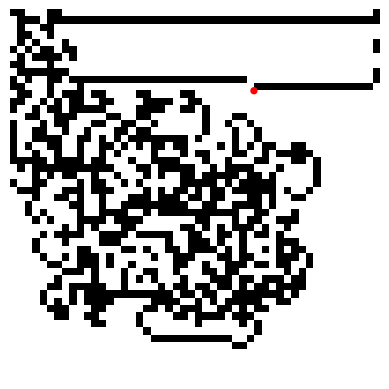

In [40]:
ant2 = LangtonsAnt(rows=50, cols=50, state_values=[0, 1, 2], ant_row=25, ant_col=25, ant_direction="down")


for i in range(11000):
    ant2.step()


fig, ax = plt.subplots()
ant2.draw(ax)
plt.axis('off')
plt.savefig('langtons_ant.png', dpi=300, bbox_inches='tight')

#### Algorithim Analysis
The Langton's ant algorithm involves updating the state of a cell and moving the ant to the next cell based on certain rules. This process is repeated for a fixed number of frames. The time complexity of updating a cell and moving the ant is O(1) since it involves simple operations like accessing and modifying array elements which can be done in constant time. Therefore, the overall time complexity of the algorithm is O(T), where T is the number of frames. The. time taken for larger or longer CA experiments will increase linearly with the number of frames. This means that the code may become slow for very large values of T. Below will be some timings of the experiment to support this analysis

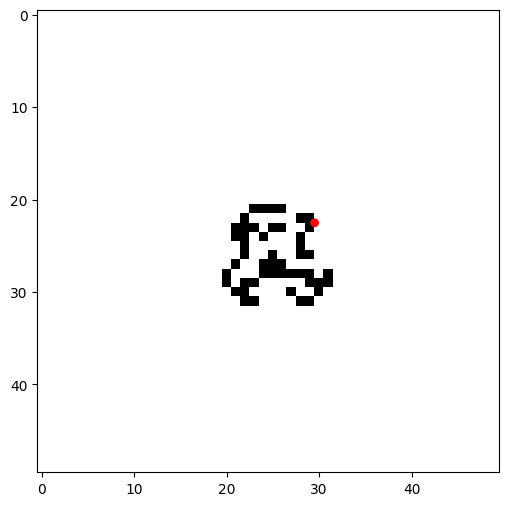

Execution time:  86.27932690900025 seconds


In [41]:
def ant():
    ant = LangtonsAnt(rows=50, cols=50, state_values=[0, 1], ant_row=25, ant_col=25, ant_direction="up")
    anim = Animation2D(ant, frames=300, figsize=(6, 6))
    return anim.animate(interval=0.05)

totaltime = timeit.timeit(ant, number=1)

print("Execution time: ", totaltime, "seconds")


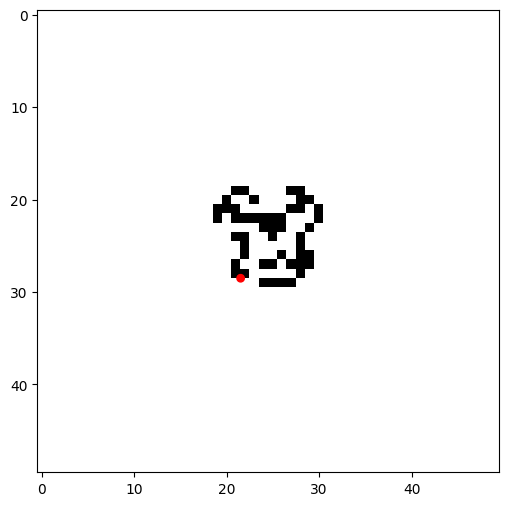

Execution time:  82.15180360000022 seconds


In [42]:
def ant2():
    ant2 = LangtonsAnt(rows=50, cols=50, state_values=[0, 1, 2, 3, 4, 5], ant_row=25, ant_col=25, ant_direction="down")
    anim = Animation2D(ant2, frames=300, figsize=(6, 6))
    return anim.animate(interval=0.05)

totaltime = timeit.timeit(ant2, number=1)

print("Execution time: ", totaltime, "seconds")


####Efficiency improvements

In chapter 8 some efficiency improvements were noted so I will try to implement them to see if they change the time complexity and if it reduces the multiplicative coefficient (linear improvement) or the constant (overhead). Below is the updated version of langtons ant with the improvements 

In [43]:
class LangtonAnt2:
    def __init__(self, width, height, steps, ant_x=None, ant_y=None):
        self.width = width
        self.height = height
        self.steps = steps
        self.grid = np.zeros((height, width), dtype=np.uint8)
        self.ant_x = ant_x if ant_x is not None else width // 2
        self.ant_y = ant_y if ant_y is not None else height // 2
        self.ant_dir = 0  # 0: up, 1: right, 2: down, 3: left
        
        self.kernel = np.array([[1, 1, 1],
                                [1,10, 1],
                                [1, 1, 1]])
        self.table = np.zeros(20, dtype=np.uint8)
        self.table[[3, 12, 13]] = 1
        
    def step(self):
        self.update()

    def update(self):
        x, y = self.ant_x, self.ant_y
        if self.grid[y, x] == 0:  # turn left
            self.ant_dir = (self.ant_dir - 1) % 4
            self.grid[y, x] = 1
        else:  # turn right
            self.ant_dir = (self.ant_dir + 1) % 4
            self.grid[y, x] = 0
        dx, dy = [(0, -1), (1, 0), (0, 1), (-1, 0)][self.ant_dir]
        self.ant_x = (x + dx) % self.width
        self.ant_y = (y + dy) % self.height

    def draw(self, ax):
        ax.imshow(self.grid, cmap='binary')
        ax.scatter(self.ant_x, self.ant_y, color='red')
        ax.axis('off')


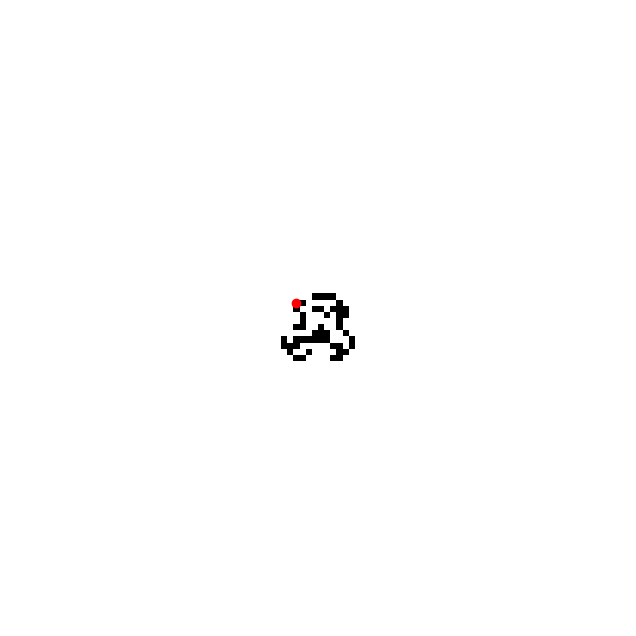

Execution time:  52.10418775400012 seconds


In [44]:
def Langtonsant2():
    ant = LangtonAnt2(100, 100, 5000)
    anim = Animation2D(ant, frames=300)
    return anim.animate(interval=0.05)

totaltime = timeit.timeit(Langtonsant2, number=1)

print("Execution time: ", totaltime, "seconds")


Compared to the original langtons ant this new langtons ant seems to run faster and be more efficeint. However, it doesn't seem to change the overall Big-O time complexity compared to the original. It seems like the new version reduces the constant overhead more than the multiplicative coefficient. The use of a kernel-based approach for updating the grid and a lookup table for determining the ant's behavior both involve fixed-size operations that can be efficiently computed using numpy array operations. This reduces the overhead of looping over each cell and checking its value, which was necessary in the original implementation